#Virtual Patients

Given a set of data about a patient group, we want to produce a way of describing their distribution without revealing individual patient identities. We can do this by releasing a set of 'virtual patients' with the same statistics as the original set, or, ideally by releasing a function which describes their distribution.

Max suggested that inducing inputs provided through sparse GP could be used to provide 'fake' data points, with all of the statistical and structural features of the original data.

Below I consider this, but find that one can still infer patient values using these values. It does however turn out that inducing inputs have properties that might be useful later. Specificially, that they can be placed sufficiently far apart for a later algorithm to operate successfully.

##Why sparse GP doesn't provide enough privacy

Below is an example with just a few data points (and only 3 inducing points).

I look at how easy it is to estimate the Xs given the outputs we will provided.

In [2]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 4
M = 3
noise_var = 0.1
X = np.linspace(0,10,N)[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
y = y

Populating the interactive namespace from numpy and matplotlib


In [3]:
k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,10,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.optimize()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f2d9216ba10>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f2d92155110>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f2d921550d0>]}

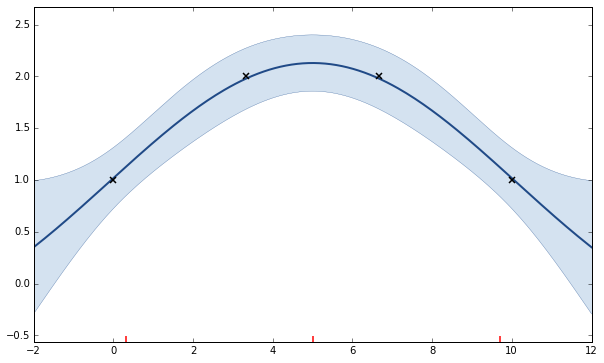

In [4]:
m.plot()

In [5]:
m.kern.K(m.Z, m.X)

array([[ 1.84774946,  1.64862501,  1.11146687,  0.56619626],
       [ 1.34975008,  1.78631287,  1.78631287,  1.34975008],
       [ 0.56619626,  1.11146687,  1.64862501,  1.84774946]])

###Estimating the inputs...

Can the user infer estimates or values of $X$ and $Y$ from:
$C$,
$\Lambda$,
$\Sigma^{-1}$ or
$Z$?

$C = \beta \Sigma^{-1} K_{UF} Y$

$\Sigma = K_{UU} + \beta K_{UF} K_{FU}$

The user has $\Sigma$ and can find $K_{UU}$ from Z and the kernel. So they have $\beta K_{UF} K_{FU}$.

What is $\beta$? Assume it can be estimated for now?

So they have $K_{UF} K_{FU}$

In [7]:
np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

array([[  7.68807932,   8.18861109,   5.75716185],
       [  8.18861109,  10.0254779 ,   8.18861109],
       [  5.75716185,   8.18861109,   7.68807932]])

**If** they can factorise this (this is the big question, that we'll look at in a second). They'll have:

In [9]:
K_uf = m.kern.K(m.Z, m.X)
print K_uf

[[ 1.84774946  1.64862501  1.11146687  0.56619626]
 [ 1.34975008  1.78631287  1.78631287  1.34975008]
 [ 0.56619626  1.11146687  1.64862501  1.84774946]]


They'll be able to easily infer X, as they know Z and the kernel.

In [10]:
Z

array([[  0.],
       [  5.],
       [ 10.]])

In [11]:
m.rbf.lengthscale.values

array([ 6.29677512])

Example, distinguishing Z locations from $K_{UF}$ matrix.

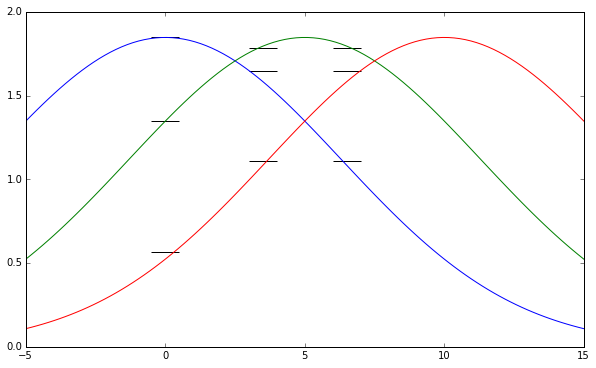

In [12]:
dom = np.linspace(-5,15,100)
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[0])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[1])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[2])**2/m.rbf.lengthscale.values**2))
plt.hlines(K_uf[:,0],-.5,.5)
plt.hlines(K_uf[:,1],3,4)
plt.hlines(K_uf[:,2],6,7)

So the question is can the $K_{UF} K_{FU}$ matrix be inverted?

It is created by the product of a pair of matrices of the form:

    [      ] x [ ] = [ ]
               [ ]
               [ ] 
               [ ]
               
I.e. wide x long. Which gives a smaller matrix, and loses lots of info. It seems like it should be impossible to factorise to recover the original values.

In [14]:
#Here's an example where we can't recover the original matrix [0,1,2], just by knowing that the sum square is 5.
import numpy as np
U = np.array([0,1,2])
np.dot(U,U.T)

5

In the example above we can't recover that the original matrix was [0,1,2].

However, if we imagine a situation in which one of the inducing inputs was placed at the location of one of the data points, a long way from other data, then the matrix might look like:

In [15]:
#In this case, the correlation of the first inducing input with the data is [.2, .5, 0], 
#ie, it is close to the first two data points.
#The second inducing input is near the third data point, and far from the first two.

U = np.array([[.2,.5,0],[0,0,1]])
print U

[[ 0.2  0.5  0. ]
 [ 0.   0.   1. ]]


In [16]:
np.dot(U,U.T)

array([[ 0.29,  0.  ],
       [ 0.  ,  1.  ]])

We know the locations of the inducing points and so, if we know the largest covariance value that can exist for that kernel (e.g. 1) then we know that one of the original data points was at the location of the second inducing point.

###Can we guess m.X?

Even though the earlier data and inducing points were mixed together, so that there were no zeros in the $K_{uf}$ matrix, it seems it's still possible to guess the locations of X from the $K_{uf} K_{fu}$ matrix and from the locations, $Z$, of the inducing points.

Rather than do anything clever, I just ask scipy to find X from the matrix.

In [17]:
A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

In [18]:
import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

In [19]:
X0 = np.array([9,4,2,10]) #np.linspace(0,1,N)
print cost(X0)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
guesses = np.array(res.values()[4])[:,None]
print guesses
print X

5.35222239776
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 410
[[  6.66666667e+00]
 [  4.47718170e-09]
 [  3.33333333e+00]
 [  1.00000000e+01]]
[[  0.        ]
 [  3.33333333]
 [  6.66666667]
 [ 10.        ]]


Clearly it has successfully found the locations of the four data points.

This seems like a trivial example (with only 4 data points, and 3 inducing inputs there's enough dof in the covariance matrix for the information about the data to be preserved)...

To see if this is a problem for a slightly more complicated example,

we consider 7 data points and 3 inducing inputs.

Populating the interactive namespace from numpy and matplotlib
[[  2.48591940e-008   9.94097688e-012   6.22846969e-022   2.26620845e-093
    3.26033275e-141   7.07594783e-240   2.04437884e-299]
 [  3.53105473e-056   4.61446197e-034   9.44817576e-019   1.19974864e-013
    1.34863861e-029   3.12584534e-077   2.95133727e-111]
 [  9.55178120e-200   4.15293142e-152   2.82901613e-111   1.32293663e-029
    1.18826028e-013   3.04853386e-010   9.57626489e-019]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 916
         Function evaluations: 1509
0.00
4.16
8.29
20.00
20.41
22.10
33.00
[[  0.]
 [  4.]
 [  8.]
 [ 20.]
 [ 25.]
 [ 33.]
 [ 37.]]
Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)
  Index  |  sparse_gp.inducing_inputs  |  Constraint  |   Prior   |  Tied to
  [0 0]  |               0.0026080189  |              |           |    N/A    
  [1 0]  |

`%matplotlib` prevents importing * from pylab and numpy


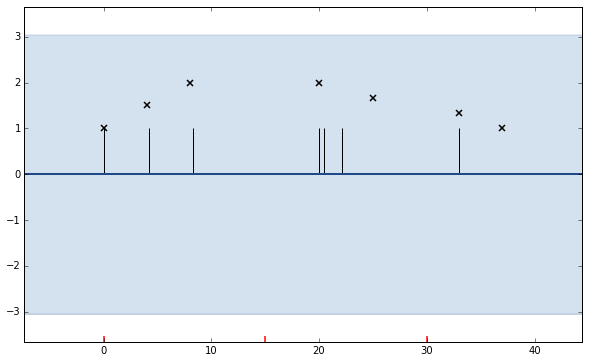

In [22]:
##Just another example, to illustrate that this can happen with more points.

%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 7
M = 3
#noise_var = 0.1
X = np.array([0.,4.,8.,20.,25.,33.,37.])[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,30,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
#m.likelihood.variance = noise_var
m.optimize()
print m.kern.K(m.Z, m.X)

A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

X0 = np.linspace(0,30,N)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxfev':10000})
guesses = np.array(res.values()[4])[:,None]
for g in guesses:
    print "%0.2f" % g
print X
print "Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)"
print m.Z
m.plot()
plt.vlines(guesses,0,1)

In the figure above the vertical lines along the x axis are the locations the search found the data points to be. One can see that for 5 of the 7 data points it correctly estimated their location, using just the three inducing inputs (indicated at the bottom of the image).

In summary, the $K_{fu} K_{uf}$ matrix can leak information about the locations of the data points, even when there are many more inputs than inducing points.

##How to provide privacy?

There are two problems the above result causes:

1. we can estimate the values of X themselves.
2. we can estimate the values of Y. This will still be uncertain as it'll have a CI surrounding it.

How to fix?

 - Move the values of the training data (add noise to X or Y)
 - Modify the $K_{uf}$ matrix (add noise there)
 - Move the positions of the inducing inputs after $K_{uf}$ is generated.
 
None of these seem ideal. I feel probably adding noise to the matrix might provide the most powerful method, but I'm not completely sure.

#Differential Privacy and GPs

We are trying to produce a function (or functional) which describes the distribution of data in some private database D. We could use a Gaussian Process to model this data, however earlier notes suggest that, even using inducing points, we can't immediately remove knowledge of the data. However, we could add noise to the data or the function.

The paper "Differential Privacy for Functions" (Hall et al.) offers a method for adding noise to an arbitrary function $f$.

> Using the notation $K_x = K(x, . )$
>
> For two functions $f = \sum^n_{i=1} \theta_i K_{x_i}$ and $g = \sum^m_{j=1} \xi_j K_{y_j}$
> the inner product is given by:
>
> $$\left< f, g \right>_H = \sum_{i=1}^n \sum_{j=1}^m \theta_i \xi_j K(x_i, y_j)$$
>
> and the corresponding norm of $f$ is $||f||_H = \sqrt{ \left< f, f \right>_H }$

> For $f \in H$ where H is the RKHS corresponding to the kernel K, and for any finite sequence $x_1...x_n$ of distinct points in T, we have:

> $||K^{-1/2} f|| \leq ||f||_H$
>
> So the release of:
>
> $\hat{f_D} = f_D + {{\Delta c(\beta)} \over \alpha} G$
>
> is $(\alpha, \beta)$-DP whenever:
>
> $\Delta \geq sup_{D \sim D'} ||f_D - f_{D'}||_H$
>
> **When $G$ is the sample path of a Gaussian process having mean zero and covariance function K, given by the reproducing kernel of H.**

In summary we can make a function private by adding a sample from a Gaussian Process (with kernel equal to the GP we're trying to make private), scaled by a constant.

##Applying this to GPs: Adding noise to the outputs (y)

So supposing the function we are trying to make private is the mean function of the GP.

$$f_* | X, y, X_* \sim N(\bar{f_*}, cov(f_*) )$$

$f_* = K(X_*,X) K(X,X)^{-1} \mathbf{y}$

(note assumes no sample noise)

We follow the pattern in the paper, and consider two values of $\mathbf{y}$:

$f_*' - f_* = \left[K(X_*,X)^\top K(X,X)^{-1} \mathbf{y'}\right] - \left[K(X_*,X)^\top K(X,X)^{-1} \mathbf{y}\right]$

$f_*' - f_* = K(X_*,X)^\top K(X,X)^{-1} \left[\mathbf{y'} - \mathbf{y}\right]$

Where we define the two $\mathbf{y}$ to be equal except for the last element, which differs by $s$.

So we can see that $\mathbf{s} = \left[\mathbf{y'} - \mathbf{y}\right] = [0,0,0,0,0,s]$. So the product $K(X,X)^{-1} \mathbf{s}$ is equal to the last column of the inverse of $K(X,X)$ multiplied by the constant $s$. If we make that column $\mathbf{a}$, then we can see that the result is:

$f_*' - f_* = \sum_{i=1}^n k_{*,x_i} a_i$

We need to put an upper bound on $f_*' - f_*$.

We can state that $k_{*,x_i} \leq 1$ [tbc], so that:

$f_*' - f_* \leq \sum_{i=1}^n a_i$

We need a constraint on the values in the final column of the $K(X,X)^{-1}$ matrix. I'm not sure what arbitrary constraints can be placed on this. **One could however restrict the possible locations of the inputs.**

This appears to be the same conclusion that is reached below when making the inputs private.

##Moving the x values might be easier.

###Representer theorem

The mean of the posterior is expressed as:

$$\bar{f_*} = \mathbf{k_*^\top} K^{-1} \mathbf{y}$$

Which can be written as a summation,

$$\bar{f_*} = \sum_{i=1}^N \alpha_i k(\mathbf{x}_i, \mathbf{x})$$

where $\mathbf{\alpha} = K^{-1} \mathbf{y}$

How does this help us apply differential privacy?

Section 4.1 of Differential Privacy for Functions provides a method for adding gaussian process samples (as noise) to a function.

I've covered most of the important steps from the paper below, while leaving out the proofs.

We again consider two datasets, which differ in their last value, $n$.

We express our posterior estimate of the mean as:

$$f_D(x) = \sum_{i=1}^n a_i k(x,x_i)$$

where $n$ is the number of elements in $\mathbf{x}$, and $\mathbf{a} = K^{-1} \mathbf{y}$

###Detour to the paper

First I consider the solution in the paper and explain it in more detail, and then I'll look at why it isn't applicable here (at least without modification).

For the example in the paper (standard kernel density estimation), the function $f_D(x)$ is:

$$f_D(x) = C \sum_{i=1}^n k(x,x_i)$$

Where $C$ is a normalisation constant.

In the paper, the sensitivity $\Delta$ must be defined to be greater or equal to the distance between $f_D$ and $f_D'$, i.e. $\Delta \geq sup_{D \sim D'} ||f_D - f_D'||_H$.

We want to put an upper bound therefore on $||f_D - f_D'||$.

####The expression for $f_D(x) - f_D'(x)$

$$f_D(x) - f_D'(x) = C \sum_{i=1}^n k(x,x_i) - C \sum_{i=1}^n k(x,x'_i)$$

when $i \neq n$, $x'_i=x_i$ and the value in the sum of both $f_D$ and $f_D'$ are equal and cancel out. This leaves just the term in the summation when $i=n$.

$$f_D(x) - f_D'(x) = C k(x,x_n) - C k(x,x_n')$$

###Detour to RKHS

What is $||f_D - f_D'||$?

The norm of $g$ is defined to be:

$||g|| = \sqrt{\left< g,g \right>}$

Substituting in our expression:

$||f_D - f_D'||^2 = \left< C k(x,x_n) - C k(x,x_n'), C k(x,x_n) - C k(x,x_n') \right>$

We can use the linear property to 'factorise' the inner product:

$||f_D - f_D'||^2 = \left< C k(x,x_n), C k(x,x_n) \right> - \left< C k(x,x_n), C k(x,x_n') \right> - \left< C k(x,x_n'), C k(x,x_n) \right> + \left< C k(x,x_n'), C k(x,x_n') \right>$

Note that the symmetry property of inner products means the two middle terms are equal. The linear property means we can move the $C$ terms out of the inner products.

$||f_D - f_D'||^2 = C^2 \Big[ \left< k(x,x_n), k(x,x_n) \right> - 2 \left< k(x,x_n), k(x,x_n') \right>  + \left< k(x,x_n'), k(x,x_n') \right> \Big]$

We now use the magic of **Reproducing Kernel Hilbert Spaces**

We can consider the kernel $k(.,x_n)$ to be a functional, returning a different function, depending on the value of $x$. In particular we can write a kernel $k(x,x_n)$ (wrt this free variable $x$) as $k_{x_n}$. So $k_{x_n}(x) = k(x,x_n)$.

The RKHS property says that:

$\left< k_x, k_y \right>_H = k(x,y)$

So we can write $\left< k(x,x_n), k(x,x_n) \right>$ as:

$$\left< k(x,x_n), k(x,x_n) \right> = \left< k_{x_n}, k_{x_n} \right>$$

which we can write using properties of RKHS as:

$$\left< k_{x_n}, k_{x_n} \right> = k(x_n,x_n)$$

So using the same logic to the other terms in the earlier expression;

$$||f_D - f_D'||^2 = C^2 \Big[ k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n') \Big]$$

###Back to the paper...

The remaining parts of the paper are quite simple,

The expression $k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n')$ is upper bounded by 2 (as each kernel $\leq$ 1).

This means that $||f_D - f_D'||^2 \leq 2 C^2$

This allows us to pick a value for $\Delta = C \sqrt{2}$ which scales the sample drawn from the gaussian process.

###Back to our problem.

Can we apply this same logic to our own problem?

We noted that the mean of the GP can be expressed as follows:

$$f_D(x) = \sum_{i=1}^n a_i k(x,x_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

So following the logic of above,

$$f_D(x) - f_D'(x) = \sum_{i=1}^n a_i k(x,x_i) - \sum_{i=1}^n a'_i k(x,x'_i)$$

The immediate problem is that $a_i \neq a'_i$ (for $i \neq n$). So we can't cancel these elements.

If we left them in, what do we get?

$$f_D(x) - f_D'(x) = \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i)$$

$$||f_D(x) - f_D'(x)||^2 = \left< \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i), \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i) \right>$$

$$||f_D(x) - f_D'(x)||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j \left< k_{x_i}, k_{x_j}\right> - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j \left< k_{x_i}, k_{x'_j}\right> + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j \left< k_{x'_i}, k_{x'_j}\right>$$

$$||f_D(x) - f_D'(x)||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(x_i, x_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(x_i, x'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(x'_i, x'_j)$$

We note that the kernels are all $\leq 1$, so:

$$||f_D(x) - f_D'(x)||^2 \leq \sum_{i=1}^n \sum_{j=1}^n a_i a_j - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j$$


$$||f_D(x) - f_D'(x)||^2 \leq \sum \mathbf{a} \mathbf{a^\top} - 2 \sum \mathbf{a} \mathbf{a'}^{\top} + \sum \mathbf{a'} \mathbf{a'}^\top$$

where these summations are over all elements in the matrix.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top - 2 \mathbf{1} \mathbf{a} \mathbf{a'}^{\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

**correction** The middle term's in the opposite direction, so we'll remove it.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

Let $G = K^{-1}$

$\Delta^2 \leq \mathbf{1 (a a^\top + a' a'^\top) 1^\top}$

substituting in for $\mathbf{a}$:

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} (G \mathbf{y})^\top + G' \mathbf{y} (G' \mathbf{y})^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} \mathbf{y}^\top G^\top + G' \mathbf{y} \mathbf{y}^\top G'^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') (\mathbf{y} \mathbf{y}^\top) (G + G')^\top 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') \mathbf{y} \mathbf{y}^\top (G + G')^\top 1^\top$

Note that $ \mathbf{1} (G + G') \mathbf{y}$ is scalar, and identical to the second half, leaving:

$\Delta^2 \leq \Big(\mathbf{1} (G + G') \mathbf{y} \Big)^2$

$\Delta \leq \mathbf{1} (G + G') \mathbf{y}$

Unfortunately this doesn't look any more generalisable. For a given pair of inverse covariance matrices, we have this bound on $\Delta$.

> Thought: Could we use this still to select $\Delta$. One needs to be careful that the value of $\Delta$ doesn't reveal information about the underlying data. A later section in the paper (4.1.2 Private Choice of Bandwidth) handles a similar problem in selecting a value of H. Could we apply a similar idea to the selection of $\Delta$. We need to find a differentially private version of $\hat{\Delta}$?

Important:

After playing with examples of K^-1 (with the rbf kernel), *I found that an upper bound on the sum of the elements in the inverse covariance matrix (for the rbf kernel) is $N$*. **To do: PROVE MATHEMATICALLY!**

This might be because the sum of the eigenvalues of some covariance matrices add up to N. When is this true? **To do: PROVE MATHEMATICALLY!**

If $|\mathbf{y}| \leq y_{max}$ is bounded, and we also bound how close together the values of $\mathbf{x}$ can be. Then the upper bound on the $G \mathbf{y}$ result is equal to $N y_{max}$.

Substituting this in

$\Delta \leq 2 N y_{max}$

##Example

For example, $N = 10$ and $y_{max}=10$.

We must ensure that $x$ is at least a certain distance apart (to be decided).

Substituting into our expression for $\Delta$:

$\Delta \leq 2 \times 10 \times 10 = 200$

Below we have a set of data that we are going to use to constrain a GP. We'll then add the appropriate noise to make it private.

In [253]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
noise_var = 0.001
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-N/2,N/2,1.)[:,None]

Populating the interactive namespace from numpy and matplotlib


In [254]:
m = GPy.models.GPRegression(X,y)
#m.likelihood.variance = noise_var
m.optimize()

{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f2d8792a4d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f2d8744c590>],
  [<matplotlib.lines.Line2D at 0x7f2d87925390>]]}

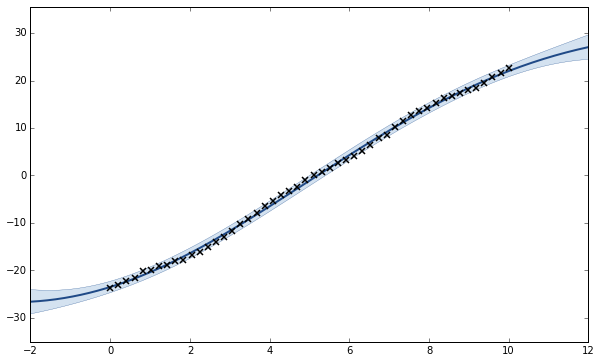

In [255]:
m.plot()

Below we try adding differential privacy to the mean function of the above GP.

With the current bounds, *the amount of noise added is very high* (completely obscures the shape of the function) for a reasonable value of $\alpha$ (often called $\epsilon$). In the example below, instead of this value being of the order of 1, it's of the order of 100s. But hopefully illustrates the idea. Note this value of $alpha$ is too high for proper use.

 /home/lionfish/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


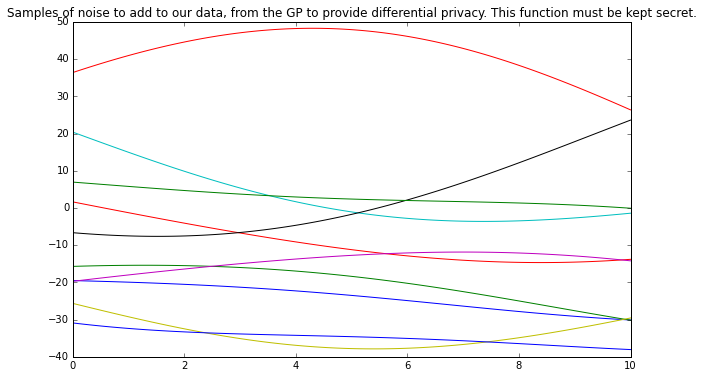

In [256]:
Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
for i in range(10):
    G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)).reshape(-1,1)
    plot(x,G)
plt.title('Samples of noise to add to our data, from the GP to provide differential privacy. This function must be kept secret.')

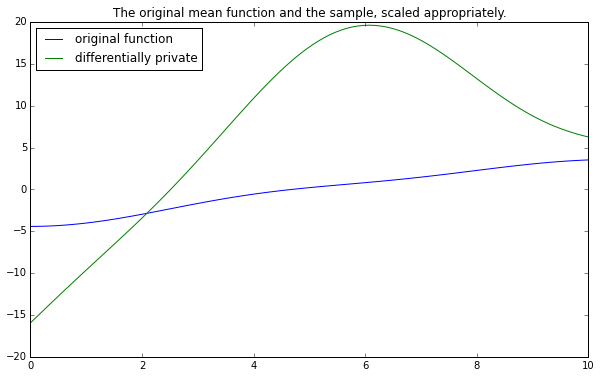

In [264]:

ypred = m.predict(x)[0]
plot(x,ypred,label='original function')
delta = 2 * N * (max(ypred)-min(ypred)) ##!!!! THIS IS NOT DIFFERENTIALLY PRIVATE ACCESS TO ymax!
alpha = 100.0 #< low but maaaybe acceptable level of privacy
beta = 0.01
c = np.sqrt(2*np.log(2/beta)) #c > sqrt(2 log (2/beta)) e.g. beta = 0.1, c = sqrt(2 log (2/0.1)) = sqrt(2 log (20)) = 2.45
scale = delta * c / alpha
plot(x,ypred+G*scale,label='differentially private')
plt.title('The original mean function and the sample, scaled appropriately.')
plt.legend(loc='upper left')

The upshot is that adding DP noise using the current bounds on the effect of $\mathbf{x_n}$ requires so much noise that the function's original shape is lost.

Alternatively... how can we make the bound a little more strict?

Going back to this step.

$$||f_D(x) - f_D'(x)||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(x_i, x_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(x_i, x'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(x'_i, x'_j)$$

We originally noted that the kernels are all $\leq 1$. But we later put a constraint on the nearnest of the values in $\mathbf{x}$, which means that most of these terms will be nearer to zero. This will provide a smaller upper bound.



If we assume that we're using the rbf kernel still and if we assume that no pair of data points lie within $d$ units of each other (using the same norm as the kernel, and with the space scaled by the length-scales of the kernel). Then the sum of the effect of all kernels on that point will be... to do, but O(1) in terms of the number of data points, and O(D) in terms of the number of dimensions.

#The $K^{-1}$ matrix

We need to find the point at which the maximum element in $K^{-1} > 1$.

Useful thoughts:

 - $K^{-1}$ can be written as $U \Lambda^{-1} U^{\top}$ where $\Lambda$ are the eigen values of $K$.
 - The eigenvalues of $K$ represent how much variance there is in each direction (pointed to by the orthogonal eigenvectors).
 - The closer together two data points, the more covariance there is between the two dimensions, making the covariance more 'skinny', and making the eigenvalue in that direction smaller.
 - With a smaller eigenvalue in $K$, one has a larger eigenvalue in $K^{-1}$.
 - As the $U$ matrix is orthonormal, we only need put a lower bound on the values of the eigenvalues for the covariance matrix.
 - It is unclear how this should be done. If we know that the inputs are all at least $d$ apart, then the most 'direct' correlation that can exist between a pair of inputs is $k(0,d)$ (assumes stationarity and monotonic tails). For example the correlation is bounded by $e^{-d^2}$. If another point is introduced, it 'takes' some of the variance from the two original points, as it is itself correlated with each of them.

To explore a little more how the distance between data points affects the smallest value in the inverse covariance matrix, I've plotted some figures.

In [74]:
import numpy as np
def k(a,b): 
    a = a[:,None]
    b = b[:,None]
    a1 = a.repeat(b.shape[0],axis=1)
    b1 = b.repeat(a.shape[0],axis=1)
    return np.exp(-(a1.T-b1)**2)

y = np.array([1,1,1,1,1,1,1,1])
idx = 0
dists = np.arange(0.05,4,0.05)
results = np.zeros_like(dists)
for dist in dists:
    x = np.array([0,dist,dist*2,dist*3,dist*4,dist*5,dist*6,dist*7])
    K = k(x,x)
    G = np.linalg.inv(k(x,x))
    s = np.abs( np.sum(np.dot(G,y)) )
    checkerboard = np.zeros_like(G)
    for i in range(checkerboard.shape[0]):
        for j in range(checkerboard.shape[1]):
            checkerboard[i,j]=1-2*((i+j) % 2)
    det = np.linalg.det(K)
    cf = np.multiply(det*G,checkerboard)
    res = np.dot(G,y)
    results[idx] = np.max(np.abs(res))
    idx = idx + 1

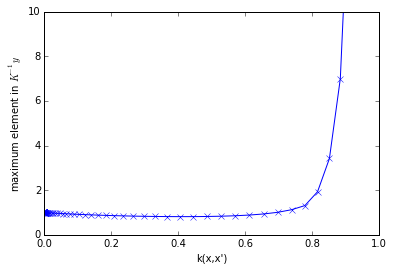

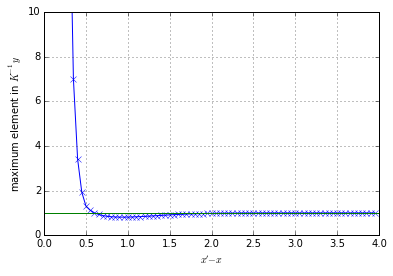

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
kervals= k(np.array([0]),dists)
#plt.plot(dists,results)
plt.plot(kervals,results,'-x')
plt.xlabel('k(x,x\')')
plt.ylabel('maximum element in $K^{-1}y$')
plt.ylim([0,10])
plt.figure()
plt.plot(dists,results,'-x')
plt.xlabel('$x\'-x$')
plt.ylabel('maximum element in $K^{-1}y$')
plt.plot([0,4],[1,1])
plt.ylim([0,10])
plt.xlim([0,4])
plt.grid()

#Ideas and things to try

- future idea: Fisher info puts a lower bound on variance (and so an upper bound on inverse variance) can we use that?%%!

- It might be that following the same logic that's been applied to the inputs, but just do it for the outputs might preserve the function's shape.

- Note that inducing inputs are aleady widely spaced, so have the properties we want.

- Other things to investigate:
    - How does releasing summary stats on users (across items) affect this?
    - Can we model this with a GP? (each release will give a joint distribution across a set of dimensions).

#Putting numbers in

To try out the earlier reasoning, I tried putting numerically estimated bounds on Gy etc.

Notes:
 - As expected the covariance eigenvalues become smaller as the dimensionality increases (due to more datapoints in close proximity providing high levels of correlation between pairs of data points). However, with y=[1,1,1..] the Gy (= K^-1 y) vector values become smaller: The reason is that, by using y=[1,1,1..]' we're sampling a point at [1,1,1] effectively. The largest value will be orthogonal to the principle component of the covariance. This we solve by just using the absolute values of the inverse covariance matrix, to find the 'worst case'.
 - The upshot is that we need to make the distance between points larger as the number of dimensions increases.
 - We need to find out what these values are (done below).
 - We will need to prove actual analytical bounds (and not use these numerical approximations).


In [248]:
def k(a,b):
    out = np.zeros((a.shape[0],b.shape[0]))
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
           # print np.sum((a[i,:]-b[j,:])**2)
            out[i,j] = np.exp(-np.sum((a[i,:]-b[j,:])**2)) #seriously need to rewrite this whole loop with some matrix algebra
            
    return out


nmax = 5
d = 2
for Ndims in range(1,6):
    if Ndims == 1:
        A=np.mgrid[0:nmax]
    if Ndims == 2:
        A=np.mgrid[0:nmax,0:nmax]
    if Ndims == 3:
        A=np.mgrid[0:nmax,0:nmax,0:nmax] #how to not make this an if?!??
    if Ndims == 4:
        A=np.mgrid[0:nmax,0:nmax,0:nmax,0:nmax] 
    if Ndims == 5:
        A=np.mgrid[0:nmax,0:nmax,0:nmax,0:nmax,0:nmax] 
    A = d*A
    
    A =A.reshape(Ndims,-1).T
    y = np.ones(A.shape[0])
  #  for i in range(Ndims):
  #      if i%2==0:
 #           y[i] = -1 #flip one to get us into right quadrant
        
    K = k(A,A)
  #  plt.matshow(K)

    G = np.linalg.inv(K)
  #  plt.matshow(G)
    print "--------------------------"
    print "Dimensions: %d" % Ndims
    #the abs is because we're interested in what the largest value for y=[1,-1,..etc]
    print "Maxmimum Gy: %0.2f" % np.max(np.dot(np.abs(G),y)) 
    #print "Sum of abs of vector: %0.2f" % np.sum(np.dot(np.abs(G),y)) 
    evals, _ = np.linalg.eig(K)
    print "Minimum eigenvalue of the covariance matrix: %0.3f" % np.min(evals)
    print "Inverse: %0.2f" % (1.0/np.min(evals))
    print "Sum of the elements in one column of the covariance matrix: %0.2f" % np.max(np.sum(K,axis=0))
    #print "So upper bound on Gy is %0.2f" % (Ndims/np.min(evals))

--------------------------
Dimensions: 1
Maxmimum Gy: 1.04
Minimum eigenvalue of the covariance matrix: 0.968
Inverse: 1.03
Sum of the elements in one column of the covariance matrix: 1.04
--------------------------
Dimensions: 2
Maxmimum Gy: 1.08
Minimum eigenvalue of the covariance matrix: 0.938
Inverse: 1.07
Sum of the elements in one column of the covariance matrix: 1.07
--------------------------
Dimensions: 3
Maxmimum Gy: 1.12
Minimum eigenvalue of the covariance matrix: 0.908
Inverse: 1.10
Sum of the elements in one column of the covariance matrix: 1.11
--------------------------
Dimensions: 4
Maxmimum Gy: 1.16
Minimum eigenvalue of the covariance matrix: 0.879
Inverse: 1.14
Sum of the elements in one column of the covariance matrix: 1.15
--------------------------
Dimensions: 5
Maxmimum Gy: 1.21
Minimum eigenvalue of the covariance matrix: 0.851
Inverse: 1.17
Sum of the elements in one column of the covariance matrix: 1.20


 /home/lionfish/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: ComplexWarning:Casting complex values to real discards the imaginary part
 /home/lionfish/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: ComplexWarning:Casting complex values to real discards the imaginary part


1.197076799290816

The above computation shows that

1. With a sufficiently large distance between points the $\mathbf{\alpha} = K^{-1} y$ part of the calculation can be bounded.

2. How many kernels contribute to a point. This also depends on the distance between points.

For a simple example, with a distance between elements of 2, and 4 dimensions:
 - The maximum value of $\alpha_i$ is 1.15
 - The total sum of kernels is 1.2
 
The upper bound is $1.15 \times 1.2 = 1.38$

Let's try this below:

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
 /home/lionfish/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: RuntimeWarning:covariance is not positive-semidefinite.


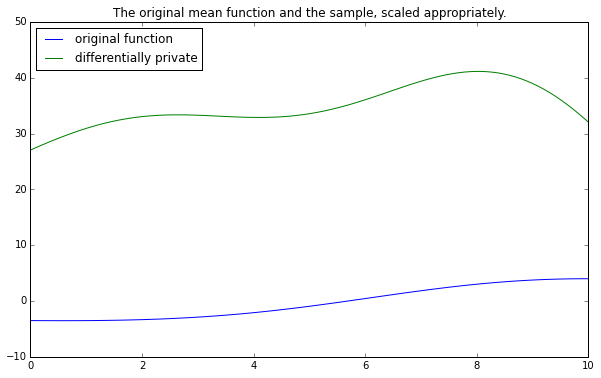

In [267]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 10
noise_var = 0.001
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-5.,5.,1.)[:,None]
m = GPy.models.GPRegression(X,y)
m.optimize()

Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)).reshape(-1,1)
    
ypred = m.predict(x)[0]
plot(x,ypred,label='original function')

d = 1.0 #how far apart the points have to be
delta = 2 * 1.38 * (max(ypred)-min(ypred)) ##!!!! THIS IS NOT DIFFERENTIALLY PRIVATE ACCESS TO ymax!
alpha = 10.0 #<<low but maybe acceptable privacy
beta = 0.01
c = np.sqrt(2*np.log(2/beta)) #c > sqrt(2 log (2/beta)) e.g. beta = 0.1, c = sqrt(2 log (2/0.1)) = sqrt(2 log (20)) = 2.45
scale = delta * c / alpha
plot(x,ypred+G*scale,label='differentially private')
plt.title('The original mean function and the sample, scaled appropriately.')
plt.legend(loc='upper left')

For the same value of $\alpha$ we have a lower amount of noise added. Making this a considerably more appropriate upper bound on the sensitivity.

To make this useful we need to prove some bounds.